# Disability Progression in Multiple Sclerosis from EDSS Scores
This tutorial notebook demonstrates the usage of some key functions in this repository.

See ``methods.ipynb`` for visualizations of individual definition aspects & combinations thereof.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(color_codes=True)
sns.set_style("whitegrid", {"grid_color": "gainsboro"})

from definitions import edssprogression
from tools import visualization, preprocessing

In [2]:
# This refreshes any modules upon change
%load_ext autoreload
%autoreload 2

## Input data format
* Data have to be provided as a Pandas dataframe, e.g. by importing an .xlsx or .csv file. 
* The data must have at least:
    * One column for the EDSS score
    * One column for the timestamp
* Relapses must be provided as a list of relapse timestamps.

See the example data in the *Single follow-up example* section.

### Important
* The timestamps must be provided as integers, e.g. as the numbers of days or weeks after baseline.
* The data have to be ordered in time from first to last assessment.
* The timestamps must be unique, i.e. there mustn't be two assessments with the same timestamp.

The section *A note on data preprocessing* shows an example workflow to convert lists of dates to the correct input format.

Note that the preprocessing is not part of the algorithm. The reason for this design choice is that
data provided in datetime format can be difficult to process when data quality is lacking, and potential
quality issues such as duplicates, inconsistent timestamps, or not well-ordered timestamps might require
the input of a subject matter expert for resolving.

## Single follow-up example

### Example data

In [3]:
example_follow_up_df = pd.DataFrame(
    [
        {"days_after_baseline": 0, "edss_score": 5.0},
        {"days_after_baseline": 10, "edss_score": 4.5},
        {"days_after_baseline": 20, "edss_score": 4.5},
        {"days_after_baseline": 30, "edss_score": 5.0},
        {"days_after_baseline": 40, "edss_score": 4.5},
        {"days_after_baseline": 50, "edss_score": 4.0},
        {"days_after_baseline": 60, "edss_score": 3.5},
        {"days_after_baseline": 70, "edss_score": 5.5},
        {"days_after_baseline": 80, "edss_score": 5.5},
        {"days_after_baseline": 90, "edss_score": 4.5},
    ]
)
example_relapse_timestamps = []

### Instantiate annotation class
See ``definitions.edssprogression.EDSSProgression`` for all available options and default values.

Examples for each option and some combinations of options are provided in ``methods.ipynb``.

In [4]:
Annot = edssprogression.EDSSProgression(
    opt_baseline_type="roving",
    opt_roving_reference_require_confirmation=True,
    opt_roving_reference_confirmation_time=0.5,  # next-confirmed
    # PIRA/RAW options - ignored if no relapses specified
    opt_raw_before_relapse_max_time=5,
    opt_raw_after_relapse_max_time=10,
    # Minimum increase options
    opt_max_score_that_requires_plus_1=5.0,
    # Confirmation options
    opt_require_confirmation=True,
    opt_confirmation_time=0.5, # next-confirmed
    # Input specifications
    edss_score_column_name="edss_score",
    time_column_name="days_after_baseline",
)

### Get the annotated events

In [5]:
Annot.add_progression_events_to_follow_up(
    follow_up_dataframe=example_follow_up_df,
    relapse_timestamps=example_relapse_timestamps,
)

,days_after_baseline,edss_score,days_since_previous_relapse,days_to_next_relapse,is_post_event_rebaseline,is_general_rebaseline,is_raw_pira_rebaseline,edss_score_used_as_new_general_reference,edss_score_used_as_new_raw_pira_reference,is_progression,progression_type,progression_score,progression_reference_score,progression_event_id,is_post_relapse_rebaseline
0,0,5.0,NaN,NaN,False,False,False,NaN,NaN,False,None,NaN,NaN,NaN,False
1,10,4.5,NaN,NaN,False,True,True,4.5,4.5,False,None,NaN,NaN,NaN,False
2,20,4.5,NaN,NaN,False,False,False,NaN,NaN,False,None,NaN,NaN,NaN,False
3,30,5.0,NaN,NaN,False,False,False,NaN,NaN,False,None,NaN,NaN,NaN,False
4,40,4.5,NaN,NaN,False,False,False,NaN,NaN,False,None,NaN,NaN,NaN,False
5,50,4.0,NaN,NaN,False,True,True,4.0,4.0,False,None,NaN,NaN,NaN,False
6,60,3.5,NaN,NaN,False,False,False,NaN,NaN,False,None,NaN,NaN,NaN,False
7,70,5.5,NaN,NaN,True,True,True,5.5,5.5,True,PIRA,5.5,4.0,1.0,False
8,80,5.5,NaN,NaN,False,False,False,NaN,NaN,False,None,NaN,NaN,NaN,False
9,90,4.5,NaN,NaN,False,False,False,NaN,NaN,False,None,NaN,NaN,NaN,False


### Plot the follow-up with the annotated events
This function creates an instance of EDSSProgression, uses it to annotate the follow-up, and then visualizes the annotated follow-up.

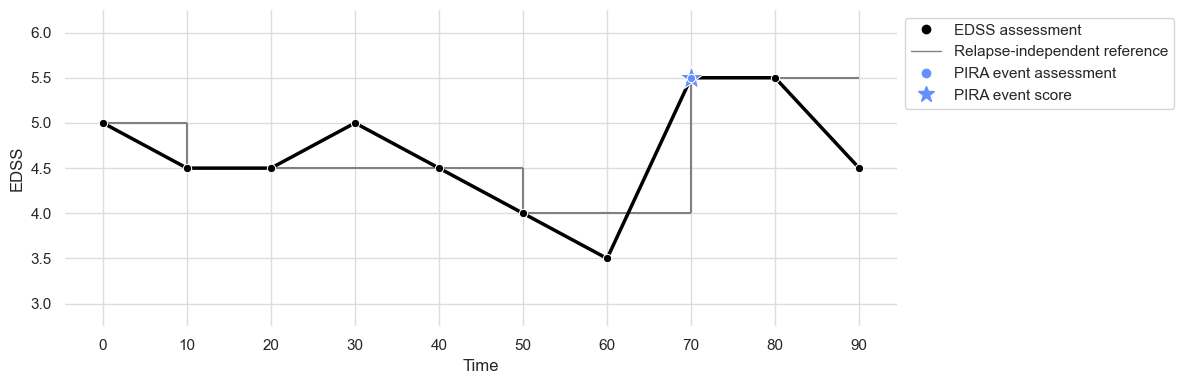

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
visualization.annotate_plot_follow_up(
    follow_up_dataframe=example_follow_up_df,
    relapse_timestamps=example_relapse_timestamps,
    # Options for EDSSProgression
    opt_baseline_type="roving",
    opt_roving_reference_require_confirmation=True,
    opt_roving_reference_confirmation_time=0.5,
    opt_raw_before_relapse_max_time=5,
    opt_raw_after_relapse_max_time=10,
    opt_max_score_that_requires_plus_1=5.0,
    opt_require_confirmation=True,
    opt_confirmation_time=0.5,
    # Plot args
    ax=ax,
)
fig.tight_layout()
sns.despine(bottom=True, left=True, right=True, top=True)
plt.show()

### Add a relapse

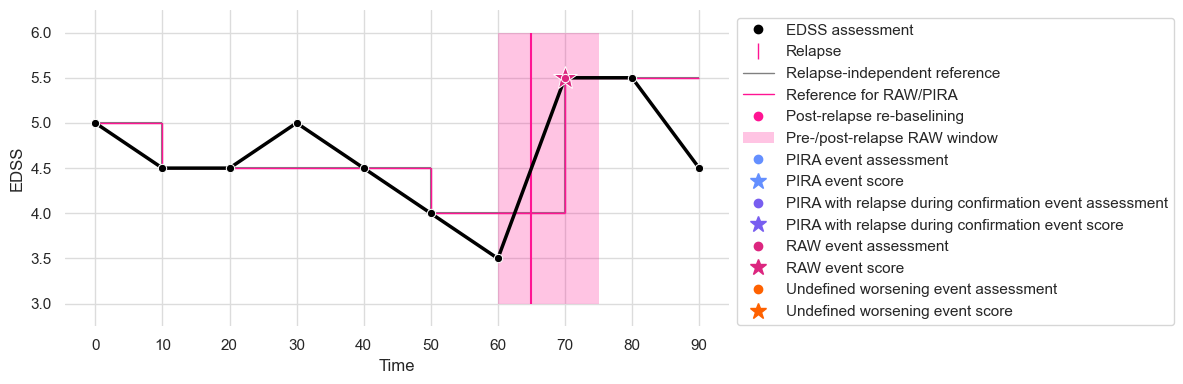

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
visualization.annotate_plot_follow_up(
    follow_up_dataframe=example_follow_up_df,
    relapse_timestamps=[65],
    # Options for EDSSProgression
    opt_baseline_type="roving",
    opt_roving_reference_require_confirmation=True,
    opt_roving_reference_confirmation_time=0.5,
    opt_raw_before_relapse_max_time=5,
    opt_raw_after_relapse_max_time=10,
    opt_max_score_that_requires_plus_1=5.0,
    opt_require_confirmation=True,
    opt_confirmation_time=0.5,
    # Plot args
    ax=ax,
)
fig.tight_layout()
sns.despine(bottom=True, left=True, right=True, top=True)
plt.show()

## Example from the Streamlit app

In [8]:
example_follow_up_df_2 = pd.DataFrame(
    [
        {"days_after_baseline": 0, "edss_score": 1.0},
        {"days_after_baseline": 60, "edss_score": 2.5},
        {"days_after_baseline": 90, "edss_score": 1.5},
        {"days_after_baseline": 150, "edss_score": 1.5},
        {"days_after_baseline": 220, "edss_score": 3.5},
        {"days_after_baseline": 250, "edss_score": 2.0},
        {"days_after_baseline": 310, "edss_score": 2.0},
        {"days_after_baseline": 370, "edss_score": 2.0},
        {"days_after_baseline": 430, "edss_score": 1.5},
        {"days_after_baseline": 490, "edss_score": 1.5},
        {"days_after_baseline": 550, "edss_score": 3.5},
        {"days_after_baseline": 580, "edss_score": 2.5},
        {"days_after_baseline": 640, "edss_score": 2.5},
        {"days_after_baseline": 700, "edss_score": 3.0},
        {"days_after_baseline": 760, "edss_score": 3.5},
        {"days_after_baseline": 820, "edss_score": 4.0},
    ]
)

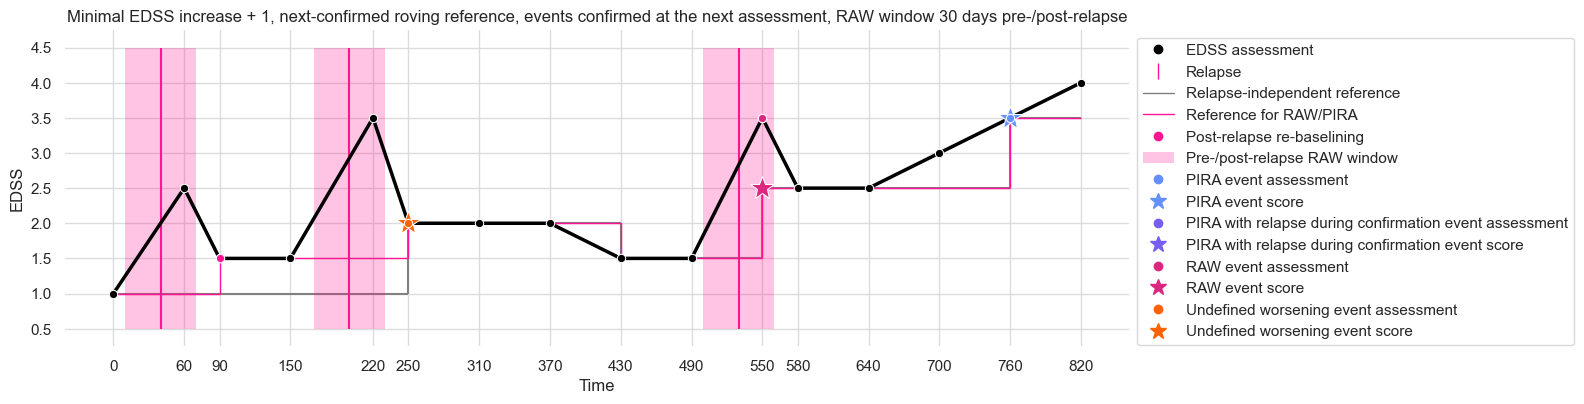

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
visualization.annotate_plot_follow_up(
    follow_up_dataframe=example_follow_up_df_2,
    relapse_timestamps=[
        40,
        200,
        530,
    ],
    # Options for EDSSProgression
    opt_baseline_type="roving",
    opt_roving_reference_require_confirmation=True,
    opt_roving_reference_confirmation_time=0.5,
    opt_raw_before_relapse_max_time=30,
    opt_raw_after_relapse_max_time=30,
    opt_max_score_that_requires_plus_1=5.0,
    opt_require_confirmation=True,
    opt_confirmation_time=0.5,
    # Plot args
    ax=ax,
)
fig.tight_layout()
ax.set_title("Minimal EDSS increase + 1, next-confirmed roving reference, events confirmed at the next assessment, RAW window 30 days pre-/post-relapse")
sns.despine(bottom=True, left=True, right=True, top=True)
plt.show()

# A note on data preprocessing

Note that data preprocessing (from datetime to integer unit after baseline)
is not part of the EDSS disability accrual annotation algorithm, since it
can be tricky if source data are of low quality (inconsistent datetime formats,
duplicate entries, not ordered properly...). 

The functions in the ``peprocessing`` module are meant as an **example** of how to 
do the preprocessing, and they are built to just throw errors if the input data 
do not satisfy some minimal formatting requirements. They do not try to fix anything, 
they don't even re-order data, you will have to take care of this.

## Example data
Data will usually be provided as a table with dates and scores, therefore
some preprocessing is required. Each raw follow-up needs to have an ID.

### EDSS scores

In [10]:
start_date = pd.Timestamp(year=2000, month=1, day=1)

In [23]:
example_data = pd.concat(
    [
        pd.DataFrame(
            {
                "follow_up_id": [0 for _ in range(10)],
                "date": [
                    start_date + pd.Timedelta(i * 10, unit="days") for i in range(10)
                ],
                "edss_score": [1.0 + 0.5 * i for i in range(10)]
            }
        ),
        pd.DataFrame(
            {
                "follow_up_id": [1 for _ in range(9)],
                "date": [
                    start_date + pd.Timedelta(i * 10, unit="days") for i in range(5)
                ]
                + [
                    start_date + pd.Timedelta(i * 10, unit="days") for i in range(6, 7)
                ]
                + [
                    start_date + pd.Timedelta((i + 1) * 10, unit="days") for i in range(7, 10)
                ],
                "edss_score": [1.0 + 0.5 * i for i in range(9)]
            }
        ),
    ]
).reset_index(drop=True)

In [24]:
example_data

,follow_up_id,date,edss_score
0,0,2000-01-01,1.0
1,0,2000-01-11,1.5
2,0,2000-01-21,2.0
3,0,2000-01-31,2.5
4,0,2000-02-10,3.0
5,0,2000-02-20,3.5
6,0,2000-03-01,4.0
7,0,2000-03-11,4.5
8,0,2000-03-21,5.0
9,0,2000-03-31,5.5


### Relapses

In [25]:
example_relapses = pd.concat(
    [
        pd.DataFrame(
            {
                "follow_up_id": [0, 0, 0],
                "date": [
                    pd.Timestamp(year=1999, month=12, day=1),
                    pd.Timestamp(year=2000, month=2, day=20),
                    pd.Timestamp(year=2000, month=12, day=1),
                ],
            }
        ),
        pd.DataFrame(
            {
                "follow_up_id": [1, 1, 1],
                "date": [
                    pd.Timestamp(year=1999, month=12, day=5),
                    pd.Timestamp(year=2000, month=2, day=25),
                    pd.Timestamp(year=2000, month=12, day=5),
                ],
            }
        ),
    ]
).reset_index(drop=True)

In [26]:
example_relapses

,follow_up_id,date
0,0,1999-12-01
1,0,2000-02-20
2,0,2000-12-01
3,1,1999-12-05
4,1,2000-02-25
5,1,2000-12-05


## Quality checks
The function ``check_input_date_data`` in the ``preprocessing`` module can be used to detect problems with input data.

### Follow-ups

In [ ]:
for follow_up_id in example_data["follow_up_id"].drop_duplicates():
    print("\nFollow-up", follow_up_id, "\n")
    preprocessing.check_input_date_data(
        input_dataframe=example_data[example_data["follow_up_id"] == follow_up_id],
        date_column_name="date",
        verbose=True,
    )


Follow-up 0 

Check date format.
Date only, proceed.

Check order and uniqueness of timestamps.
Unique and well ordered.

Follow-up 1 

Check date format.
Date only, proceed.

Check order and uniqueness of timestamps.
Unique and well ordered.


### Relapses

In [ ]:
for follow_up_id in example_relapses["follow_up_id"].drop_duplicates():
    print("\nFollow-up", follow_up_id, "\n")
    preprocessing.check_input_date_data(
        input_dataframe=example_relapses[example_relapses["follow_up_id"] == follow_up_id],
        date_column_name="date",
        verbose=True,
    )


Follow-up 0 

Check date format.
Date only, proceed.

Check order and uniqueness of timestamps.
Unique and well ordered.

Follow-up 1 

Check date format.
Date only, proceed.

Check order and uniqueness of timestamps.
Unique and well ordered.


### Examples of well- and ill-formatted data

In [27]:
# Monotonically increasing, no time part
preprocessing.check_input_date_data(
    input_dataframe=pd.DataFrame(
        {"date": [pd.Timestamp(year=2000, month=1, day=1), pd.Timestamp(year=2000, month=1, day=2)]}
    ),
    date_column_name="date",
    verbose=True,
)

Check date format.
Date only, proceed.

Check order and uniqueness of timestamps.
Unique and well ordered.


#### Ill-formatted timestamps

In [ ]:
# Time part in timestamp raises ValueError
preprocessing.check_input_date_data(
    input_dataframe=pd.DataFrame(
        {"date": [pd.Timestamp(year=2000, month=1, day=1, hour=12), pd.Timestamp(year=2000, month=1, day=2)]}
    ),
    date_column_name="date",
    verbose=True,
)

#### Duplicate timestamps

In [ ]:
# Duplicate timestamp raises ValueError
preprocessing.check_input_date_data(
    input_dataframe=pd.DataFrame(
        {"date": [pd.Timestamp(year=2000, month=1, day=1), pd.Timestamp(year=2000, month=1, day=1)]}
    ),
    date_column_name="date",
    verbose=True,
)

#### Timestamps not ordered

In [ ]:
# Non-monotonically increasing timestamps raise ValueError
preprocessing.check_input_date_data(
    input_dataframe=pd.DataFrame(
        {"date": [pd.Timestamp(year=2000, month=1, day=2), pd.Timestamp(year=2000, month=1, day=1)]}
    ),
    date_column_name="date",
    verbose=True,
)

## Preprocess follow-ups

### One single follow-up
The function ``find_connected_blocks`` adds IDs of connected blocks to an input dataframe.

Runs the quality check on each follow-up, so if one of them is not well-formatted,
it will throw an error.

Assessments that are not part of a connected follow-up block have no block ID.

For each block, the integer timestamp column starts at 0.

In [28]:
preprocessing.find_connected_blocks(
    input_dataframe=example_data.query("follow_up_id == 1"),
    max_days_between_timestamps=10,
    min_days_overall=20,
    min_n_timestamps=0,
    date_column_name="date",
    block_id_start=0,
    block_id_column_name="block_id",
    block_baseline_flag_column_name="is_block_baseline",
    days_after_baseline_column_name="days_after_baseline",
    tests_verbose=False,
)

,follow_up_id,date,edss_score,block_id,is_block_baseline,days_after_baseline
10,1,2000-01-01,1.0,0.0,True,0.0
11,1,2000-01-11,1.5,0.0,False,10.0
12,1,2000-01-21,2.0,0.0,False,20.0
13,1,2000-01-31,2.5,0.0,False,30.0
14,1,2000-02-10,3.0,0.0,False,40.0
15,1,2000-03-01,3.5,NaN,False,NaN
16,1,2000-03-21,4.0,1.0,True,0.0
17,1,2000-03-31,4.5,1.0,False,10.0
18,1,2000-04-10,5.0,1.0,False,20.0


### A dataframe with multiple follow ups
The function ``prepare_follow_ups`` returns all connected follow-up blocks, and drops assessments that are not part of a connected follow-up.

Runs the quality check on each follow-up, so if one of them is not well-formatted,
it will throw an error.

The block IDs are unique over the entire dataframe.

In [29]:
preprocessing.prepare_follow_ups(
    follow_ups_dataframe=example_data,
    max_days_between_timestamps=10,
    min_days_overall=20,
    min_n_timestamps=0,
    id_column_name="follow_up_id",
    date_column_name="date",
    days_after_baseline_column_name="days_after_baseline",
)

,follow_up_id,date,edss_score,block_id,is_block_baseline,days_after_baseline
0,0,2000-01-01,1.0,0,True,0
1,0,2000-01-11,1.5,0,False,10
2,0,2000-01-21,2.0,0,False,20
3,0,2000-01-31,2.5,0,False,30
4,0,2000-02-10,3.0,0,False,40
5,0,2000-02-20,3.5,0,False,50
6,0,2000-03-01,4.0,0,False,60
7,0,2000-03-11,4.5,0,False,70
8,0,2000-03-21,5.0,0,False,80
9,0,2000-03-31,5.5,0,False,90


## Sync and preprocess relapses
Requires the processed follow-ups as input. Works on single and multiple follow-ups.

Runs quality checks on the relapses dataframe.

In [56]:
preprocessing.sync_relapse_data_to_follow_ups(
    preprocessed_follow_ups_dataframe=preprocessing.prepare_follow_ups(
        follow_ups_dataframe=example_data,
        max_days_between_timestamps=10,
        min_days_overall=20,
        min_n_timestamps=0,
        id_column_name="follow_up_id",
        date_column_name="date",
        days_after_baseline_column_name="days_after_baseline",
    ),
    relapses_dataframe=example_relapses,
    id_column_name="follow_up_id",
    date_column_name="date",
    days_after_baseline_column_name="days_after_baseline",
    block_baseline_flag_column_name="is_block_baseline",
)

,follow_up_id,block_baseline_date,edss_score,block_id,relapse_date,days_after_baseline
0,0,2000-01-01,1.0,0,1999-12-01,-31
1,0,2000-01-01,1.0,0,2000-02-20,50
2,0,2000-01-01,1.0,0,2000-12-01,335
3,1,2000-01-01,1.0,1,1999-12-05,-27
4,1,2000-01-01,1.0,1,2000-02-25,55
5,1,2000-01-01,1.0,1,2000-12-05,339
6,1,2000-03-21,4.0,2,1999-12-05,-107
7,1,2000-03-21,4.0,2,2000-02-25,-25
8,1,2000-03-21,4.0,2,2000-12-05,259


## Full workflow - use preprocessed data as input for annotation

In [57]:
preprocessed_follow_ups = preprocessing.prepare_follow_ups(
    follow_ups_dataframe=example_data,
    max_days_between_timestamps=10,
    min_days_overall=20,
    min_n_timestamps=0,
    id_column_name="follow_up_id",
    date_column_name="date",
    days_after_baseline_column_name="days_after_baseline",
)

In [58]:
preprocessed_relapses = preprocessing.sync_relapse_data_to_follow_ups(
    preprocessed_follow_ups_dataframe=preprocessed_follow_ups,
    relapses_dataframe=example_relapses,
    id_column_name="follow_up_id",
    date_column_name="date",
    days_after_baseline_column_name="days_after_baseline",
    block_baseline_flag_column_name="is_block_baseline",
)

In [59]:
preprocessed_follow_ups.head()

,follow_up_id,date,edss_score,block_id,is_block_baseline,days_after_baseline
0,0,2000-01-01,1.0,0,True,0
1,0,2000-01-11,1.5,0,False,10
2,0,2000-01-21,2.0,0,False,20
3,0,2000-01-31,2.5,0,False,30
4,0,2000-02-10,3.0,0,False,40


In [60]:
preprocessed_relapses.head()

,follow_up_id,block_baseline_date,edss_score,block_id,relapse_date,days_after_baseline
0,0,2000-01-01,1.0,0,1999-12-01,-31
1,0,2000-01-01,1.0,0,2000-02-20,50
2,0,2000-01-01,1.0,0,2000-12-01,335
3,1,2000-01-01,1.0,1,1999-12-05,-27
4,1,2000-01-01,1.0,1,2000-02-25,55


#### Example of running annotation algorithm

In [44]:
for block_id in preprocessed_follow_ups["block_id"].drop_duplicates():
    Annot.add_progression_events_to_follow_up(
        follow_up_dataframe=preprocessed_follow_ups[preprocessed_follow_ups["block_id"] == block_id],
        relapse_timestamps=preprocessed_relapses[preprocessed_relapses["block_id"] == block_id]["days_after_baseline"],
    )